# 데이터 불러오기

In [41]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

diabetes = pd.read_csv('./datasets/diabetes (3).csv')
diabetes.head(1)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1


In [42]:
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


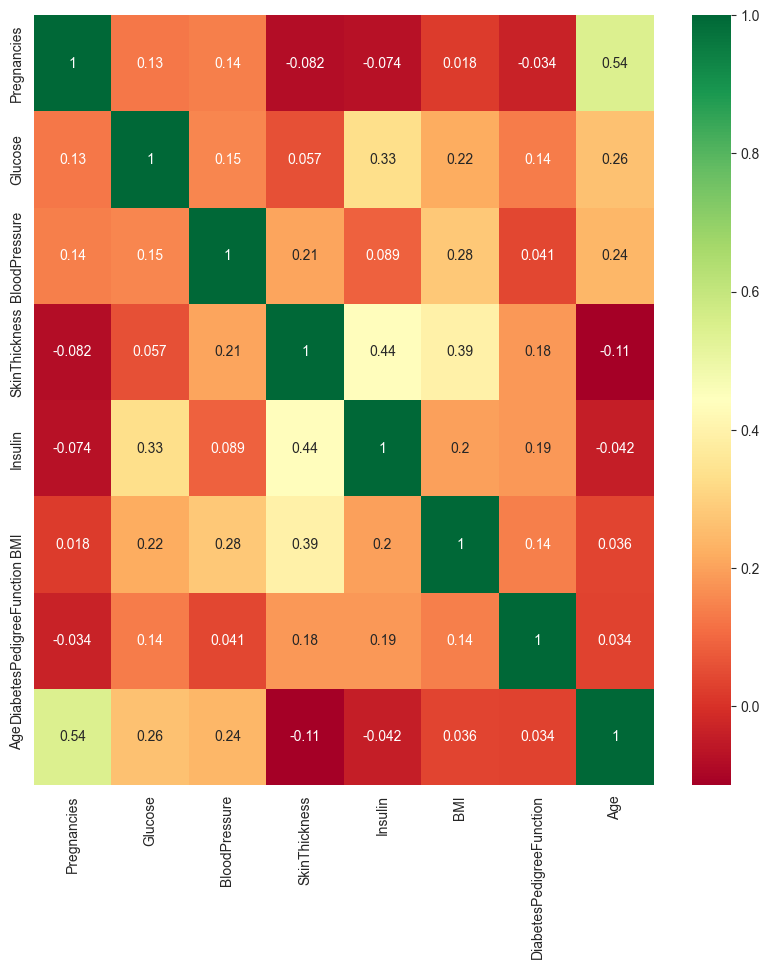

In [52]:
%matplotlib inline 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style('whitegrid')
plt.figure(figsize=(10,10))
p = sns.heatmap(diabetes.corr(),annot=True,cmap='RdYlGn')

In [43]:
diabetes['Outcome'] = diabetes['Outcome'].astype('category')

In [44]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve

# 저번에 작성한 것에 ROC AUC를 추가함
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred)
    
    print('오차행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'
          .format(accuracy, precision, recall, f1, roc_auc))
    
# get_eval_by_threshold()
def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    # thresholds list 객체 내의 값을 차례로 iteration하면서 evaluation 수행
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print(f'임곗값: {custom_threshold}')
        get_clf_eval(y_test, custom_predict)

# precision_recall_curve_plot()
def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행, 정밀도는 점선으로 표시
    plt.figure(figsize=(8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    # threshold 값 X축의 scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    # X, Y축 label과 legend, grid 설정
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()

In [54]:
# 피처 데이터 세트 X, 레이블 데이터 세트 y를 추출
# 맨 끝이 Outcome 칼럼으로 레이블 값임, 칼럼 위치 -1을 이용해 추출
X = diabetes.loc[:,['Insulin', 'BMI','Glucose']]
y = diabetes['Outcome']

# stratify: default=None 이고, stratify 값을 target으로 지정해주면 각각의 class 비율(ratio)을 train / validation에 유지해 준다. (즉, 한 쪽에 쏠려서 분배되는 것을 방지)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156, stratify=y)

# 로지스틱 회귀로 학습, 예측, 평가 
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, pred, pred_proba)

오차행렬
[[87 13]
 [25 29]]
정확도: 0.7532, 정밀도: 0.6905, 재현율: 0.5370, F1: 0.6042, AUC:0.7035


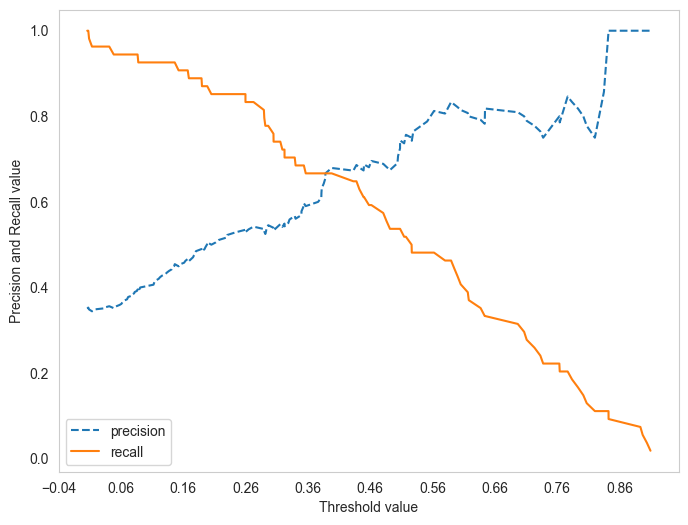

In [55]:
pred_proba_c1 = lr_clf.predict_proba(X_test)[:, 1]
precision_recall_curve_plot(y_test, pred_proba_c1)

In [56]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일때의 예측 확률을 추측
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)

# 반환된 임곗값 배열에서 샘플로 데이터를 추출하되, 임곗값을 5 step으로 추출
# threshold[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작 
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index:', thr_index)
print('샘플 index로 추출한 임곗값:', np.round(thresholds[thr_index],2))

# 5 step으로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임계값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임계값별 TPR: ', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index: [ 1  6 11 16 21 26 31 36 41 46 51]
샘플 index로 추출한 임곗값: [0.91 0.76 0.58 0.51 0.45 0.35 0.32 0.27 0.19 0.15 0.01]
샘플 임계값별 FPR:  [0.   0.03 0.06 0.1  0.16 0.25 0.33 0.38 0.5  0.6  0.99]
샘플 임계값별 TPR:  [0.019 0.222 0.463 0.537 0.611 0.685 0.722 0.833 0.87  0.926 0.963]


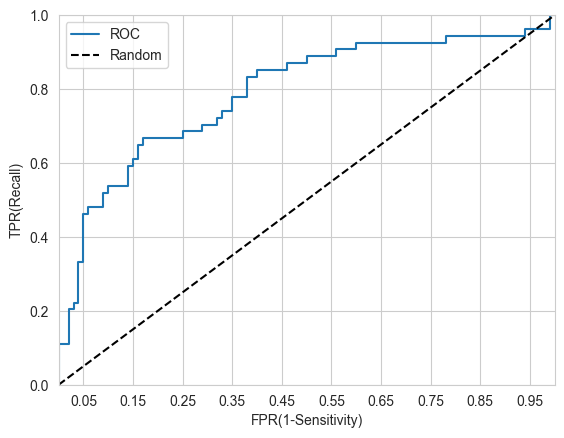

In [57]:
plt.plot(fprs, tprs, label = 'ROC')
# 가운데 대각선 직선을 그림
plt.plot([0,1], [0,1], 'k--', label='Random')
    
# FPR X축의 scale을 0.1 단위로 변경, X, Y 축명 설정등
start, end = plt.xlim()
plt.xticks(np.round(np.arange(start, end, 0.1), 2))
plt.xlim(0,1); plt.ylim(0,1)
plt.xlabel('FPR(1-Sensitivity)'); plt.ylabel('TPR(Recall)')
plt.legend()
plt.show()

In [58]:
from sklearn.metrics import roc_auc_score

pred_proba = lr_clf.predict_proba(X_test)[:,1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값: {0: .4f}'.format(roc_score))

ROC AUC 값:  0.7894
